<a href="https://colab.research.google.com/github/jasxn808/Generalized-Linear-Model-GLM-/blob/main/GLM_3rd_down_Conversion_over_Expected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nfl_data_py

In [4]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
seasons = range(2016, 2022+1)

df = \
 nfl.import_pbp_data(seasons)

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

## 3rd down conversion:
## cols:

cols = \
  [
      'desc'
      , 'ydstogo'
      , 'air_yards'
      , 'passer_id'
      , 'passer_player_name'
      , 'season'
      , 'third_down_converted'
      , 'number_of_pass_rushers'
      , 'two_point_conversion_prob'
  ]

pbp_py_third = \
df\
  .query('play_type == "pass" & down == 3.0')

In [125]:
#pbp_py_third.isnull().sum
pbp_py_third = \
  pbp_py_third.query('air_yards.notnull() & ydstogo <= 15').reset_index()

[[<matplotlib.axis.XTick at 0x7cfd0175a650>,

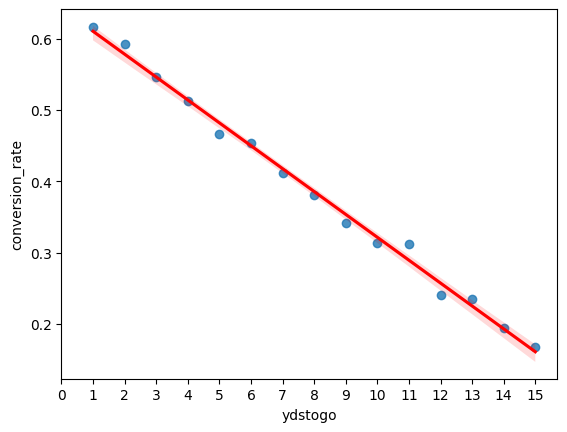

In [126]:
#conversion rate based on ydstogo
df_conv = \
pbp_py_third \
    .groupby('ydstogo')\
    .agg({'third_down_converted':['mean', 'count']})

df_conv.columns = list(map('_'.join, df_conv.columns))
df_conv.reset_index(inplace=True)

df_conv.rename(columns = \
    {'third_down_converted_mean':'conversion_rate', 'third_down_converted_count':'n'}, inplace=True)


plt = \
sns.regplot\
  (data=df_conv
   , x='ydstogo'
   , y='conversion_rate'
   , line_kws={'color':'red'})


plt.set(xticks=np.arange(0,16,1))

In [127]:
conversion_py = \
  smf.glm(formula='third_down_converted ~ ydstogo',
          data=pbp_py_third,
          family=sm.families.Binomial())\
          .fit()

conversion_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     third_down_converted   No. Observations:                31964
Model:                              GLM   Df Residuals:                    31962
Model Family:                  Binomial   Df Model:                            1
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -20895.
Date:                  Fri, 27 Oct 2023   Deviance:                       41791.
Time:                          17:04:12   Pearson chi2:                 3.19e+04
No. Iterations:                       5   Pseudo R-squ. (CS):            0.05422
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6233      0.025     24.788      0.000       0.574       0.673
ydstogo       -0.1410      0.003    -40.651      0.000      -0.148      -0.134
==============================================================================
"""

In [128]:
#expected conversion rate based on ydstogo:

pbp_py_third['exp_third_conv'] = \
  conversion_py.predict()

#CROE = Conversion Rate over Expected
pbp_py_third['CROE'] = \
  pbp_py_third['third_down_converted'] - pbp_py_third['exp_third_conv']

In [150]:
#In Python, calculate the mean CPOE and the mean completed pass percentage, and then sort by compl:

croe_leaders = \
pbp_py_third\
  .groupby(['season', 'passer_player_id', 'passer_player_name'])\
  .agg({'CROE':['mean'],
       'third_down_converted':['mean','sum']})


croe_leaders.columns = \
  list(map('_'.join, croe_leaders.columns))

croe_leaders.reset_index(inplace=True)
croe_leaders.rename\
  (columns = {'CROE_mean':'CROE_avg', 'third_down_converted_mean':'avg_conv_rate', 'third_down_converted_sum':'n'}, inplace=True)

#greater than 50 third down attempts
croe_leaders.sort_values(by='CROE_avg', ascending=False).query('n>50')

,season,passer_player_id,passer_player_name,CROE_avg,avg_conv_rate,n
0,2016,00-0019596,T.Brady,0.113852,0.550000,77.0
419,2021,00-0033873,P.Mahomes,0.109437,0.552147,90.0
134,2017,00-0032950,C.Wentz,0.106804,0.522124,59.0
207,2018,00-0033873,P.Mahomes,0.103317,0.531250,68.0
20,2016,00-0026143,M.Ryan,0.100768,0.517986,72.0
...,...,...,...,...,...,...
451,2021,00-0036971,T.Lawrence,-0.055981,0.375887,53.0
107,2017,00-0029604,K.Cousins,-0.065626,0.356164,52.0
7,2016,00-0022803,E.Manning,-0.065884,0.370588,63.0
41,2016,00-0029682,B.Osweiler,-0.067891,0.363057,57.0


In [ ]:
## creating second model that includes more features:
# features: qb_hit, number_of_pass_rushers, yardline_100, air_yards

pbp_py_third['qb_hit'] = \
  pbp_py_third['qb_hit'].astype(str)


pbp_py_third_compl = \
  pbp_py_third[['passer', 'passer_id', 'passer_player_name',
                'season', 'down', 'third_down_converted',
                'ydstogo', 'yardline_100', 'qb_hit', 'number_of_pass_rushers', 'air_yards']]\
                .dropna(axis = 0)  #drop rows where nulls exist

In [173]:
conversion_v2_py = \
  smf.glm(formula='third_down_converted ~ ydstogo + qb_hit + number_of_pass_rushers + yardline_100 + air_yards'
          , data=pbp_py_third_compl
          , family=sm.families.Binomial())\
          .fit()

conversion_v2_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     third_down_converted   No. Observations:                31802
Model:                              GLM   Df Residuals:                    31796
Model Family:                  Binomial   Df Model:                            5
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -20599.
Date:                  Fri, 27 Oct 2023   Deviance:                       41198.
Time:                          17:30:06   Pearson chi2:                 3.17e+04
No. Iterations:                       4   Pseudo R-squ. (CS):            0.06560
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4176      0.070      5.995      0.000       0.281       0.554
qb_hit[T.1.0]             -0.6139      0.038    -16.027      0.000      -0.689      -0.539
ydstogo                   -0.1465      0.004    -41.001      0.000      -0.154      -0.140
number_of_pass_rushers     0.0080      0.014      0.578      0.563      -0.019       0.035
yardline_100               0.0039      0.000      7.849      0.000       0.003       0.005
air_yards                  0.0096      0.001      7.653      0.000       0.007       0.012
==========================================================================================
"""

In [ ]:
#calculating SROE after adding addt'l features:
pbp_py_third_compl['exp_third_conv'] = \
  conversion_v2_py.predict()

pbp_py_third_compl['SROE'] =\
  pbp_py_third_compl['third_down_converted'] - pbp_py_third_compl['exp_third_conv']



In [204]:
pbp_py_third_convr = \
pbp_py_third_compl\
  .groupby(['passer_id', 'passer_player_name', 'season'])\
  .agg({'SROE':['mean'],\
        'third_down_converted':['mean','count']})

pbp_py_third_convr.columns = list(map('_'.join, pbp_py_third_convr))
pbp_py_third_convr.reset_index(inplace=True)

pbp_py_third_convr\
  .rename(columns={'SROE_mean':"SROE", 'third_down_converted_mean':'avg_conversion','third_down_converted_count':'n'}\
          ,inplace=True)

pbp_py_third_convr.sort_values(by='SROE', ascending=False).query('n > 50')

,passer_id,passer_player_name,season,SROE,avg_conversion,n
389,00-0033873,P.Mahomes,2021,0.114987,0.552147,163
73,00-0026143,M.Ryan,2016,0.113641,0.517986,139
326,00-0032950,C.Wentz,2017,0.112742,0.522124,113
0,00-0019596,T.Brady,2016,0.108437,0.550000,140
386,00-0033873,P.Mahomes,2018,0.108434,0.531250,128
...,...,...,...,...,...,...
41,00-0023436,A.Smith,2020,-0.113125,0.288462,52
284,00-0031589,B.Hundley,2017,-0.121331,0.333333,81
179,00-0029567,N.Foles,2020,-0.122218,0.287671,73
83,00-0026158,J.Flacco,2019,-0.125113,0.323077,65


In [ ]:
## CPOE stability analysis:
third_LY = pbp_py_third_convr.copy()
third_CY = pbp_py_third_convr.copy()


third_LY['season'] += 1


df_merged = \
  third_CY\
    .merge(third_LY,
          how='inner',
          on=['season', 'passer_id','passer_player_name'])

df_merged\
  .rename(columns = {'SROE_x':'SROE_CY', 'avg_conversion_x':'conv_rate_CY', 'n_x':'n_CY'
                      , 'SROE_y':'SROE_LY', 'avg_conversion_y':'conv_rate_LY', 'n_y': 'n_LY'}, inplace=True)

df_merged = \
  df_merged.query('n_CY >= 50 & n_LY >= 50')

In [219]:
## correlation comparison:

df_merged[['SROE_CY', 'SROE_LY']].corr()

,SROE_CY,SROE_LY
SROE_CY,1.000000,0.363198
SROE_LY,0.363198,1.000000


In [220]:
df_merged[['conv_rate_CY', 'conv_rate_LY']].corr()

,conv_rate_CY,conv_rate_LY
conv_rate_CY,1.00000,0.34131
conv_rate_LY,0.34131,1.00000


In [279]:
#data viz:
qb1 = \
  pbp_py_third_convr.query('n>50') \
  .groupby(['passer_id', 'passer_player_name']) \
  .agg({'SROE':['mean', 'count']})



qb1.columns = \
  list(map('_'.join, qb1.columns))


qb1.rename(columns = {'SROE_count':'numb_seasons'}, inplace=True)

qb1.reset_index(inplace=True)

df_top_qbs = \
  qb1.sort_values(by='SROE_mean', ascending=False).query('numb_seasons > 2').head(10)




,passer_id,passer_player_name,SROE_mean,numb_seasons
49,00-0033873,P.Mahomes,0.085201,5
34,00-0031345,J.Garoppolo,0.082571,3
36,00-0031503,J.Winston,0.079852,4
13,00-0026143,M.Ryan,0.064718,7
69,00-0036442,J.Burrow,0.062632,3
67,00-0036355,J.Herbert,0.043733,3
15,00-0026498,M.Stafford,0.041428,7
6,00-0022942,P.Rivers,0.031302,5
8,00-0023459,A.Rodgers,0.027687,6
57,00-0034857,J.Allen,0.027402,5


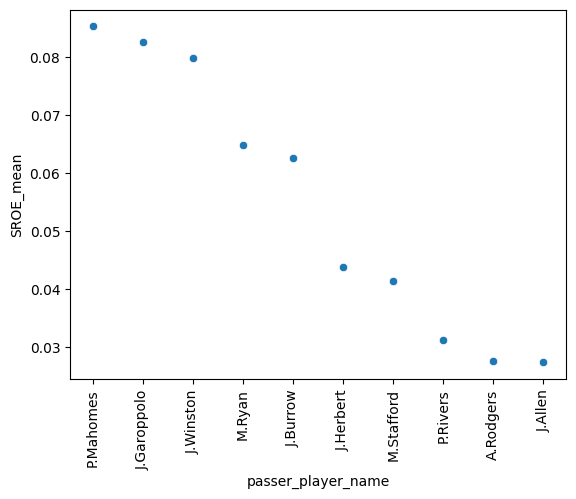

In [280]:
g =\
  sns.scatterplot(data=df_top_qbs, x="passer_player_name", y="SROE_mean");
g.tick_params(axis='x', rotation=90)